### DATES IMAGE CLASSIFIFCATION 

In [1]:
#importing important libraries 
# Imports
#not all used
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
from fastai import *
from fastai.vision import *
from fastai.metrics import error_rate
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from keras.models import Sequential
from keras import layers
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from tensorflow.keras.utils import img_to_array,  load_img
import matplotlib.pyplot as plt
from PIL import Image 
from glob import glob

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip "/content/drive/MyDrive/open.zip"

Archive:  /content/drive/MyDrive/open.zip
   creating: open/
   creating: open/bumaan/
  inflating: open/bumaan/100_o.jpg   
  inflating: open/bumaan/101_o.jpg   
  inflating: open/bumaan/102_o.jpg   
  inflating: open/bumaan/103_o.jpg   
  inflating: open/bumaan/104_o.jpg   
  inflating: open/bumaan/105_o.jpg   
  inflating: open/bumaan/106_o.jpg   
  inflating: open/bumaan/107_o.jpg   
  inflating: open/bumaan/108_o.jpg   
  inflating: open/bumaan/109_o.jpg   
  inflating: open/bumaan/10_o.jpg    
  inflating: open/bumaan/110_o.jpg   
  inflating: open/bumaan/111_o.jpg   
  inflating: open/bumaan/112_o.jpg   
  inflating: open/bumaan/113_o.jpg   
  inflating: open/bumaan/114_o.jpg   
  inflating: open/bumaan/115_o.jpg   
  inflating: open/bumaan/116_o.jpg   
  inflating: open/bumaan/117_o.jpg   
  inflating: open/bumaan/118_o.jpg   
  inflating: open/bumaan/119_o.jpg   
  inflating: open/bumaan/11_o.jpg    
  inflating: open/bumaan/120_o.jpg   
  inflating: open/bumaan/121_o.jpg   
 

In [4]:
import pathlib
data_dir = pathlib.Path('/content/open') # make a directory "data_dir"/content/drive/MyDrive/DatesImages/DatesImages
path = Path(data_dir)
path.ls() #list all the folders of dates images.
path

Path('/content/open')

In [5]:
def number_of_images_in_dataset(dataset):
  images = list(dataset.glob("*/*.*"))
  return len(images)
print("number of all images in dataset: {}".format(number_of_images_in_dataset(data_dir)))

number of all images in dataset: 1000



# Visualization

In [6]:
# class_names=['bumaan', 'fardh', 'khalas', 'lulu', 'shishi']
num_class = 5

print( num_class)

5


In [7]:
import tensorflow as tf
batch_size = 128 #The batch size defines the number of samples that will be propagated through the network 
img_height = 256
img_width = 256

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  class_names=['bumaan', 'fardh', 'khalas', 'lulu', 'shishi'],
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  class_names=['bumaan', 'fardh', 'khalas', 'lulu', 'shishi'],
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)



print("Label names:", class_names)
print("Image dimensions:", img_width, "x", img_height)
num_class = len(class_names)
print(" number of classes", num_class)
#You will use 80% of the images for training and 20% for validation.

Found 1000 files belonging to 5 classes.
Using 800 files for training.
Found 1000 files belonging to 5 classes.
Using 200 files for validation.
Label names: ['bumaan', 'fardh', 'khalas', 'lulu', 'shishi']
Image dimensions: 256 x 256
 number of classes 5


In [8]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(128, 256, 256, 3)
(128,)


Standardize the data
The RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, you will standardize values to be in the [0, 1] range by using tf.keras.layers.Rescaling:

In [9]:
normalization_layer = tf.keras.layers.Rescaling(1./255)


In [10]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.99864435


Dataset.cache keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
Dataset.prefetch overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [12]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.4),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
  layers.RandomTranslation(height_factor=0.5, width_factor=0.5),
  layers.RandomZoom(0.4)
])


# TRAIN MODEL

### VGG19

In [13]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import Model
pretrained_model=ResNet50(input_shape = (256, 256, 3), 
                        include_top = False, 
                        weights = 'imagenet')

for layer in pretrained_model.layers:
     layer.trainable = False

# pretrained_model.summary()
last_layer = pretrained_model.get_layer('conv5_block3_out')
print('last layer of resnet : output shape: ', last_layer.output_shape)
last_output= last_layer.output

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)                  
x = layers.Dense(5, activation='softmax') (x)       

model_rn = Model(pretrained_model.input, x) 


from tensorflow.keras.optimizers import RMSprop
model_rn.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'sparse_categorical_crossentropy', 
              metrics = ['acc'])


94765736/94765736 [==============================] - 5s 0us/step
last layer of resnet : output shape:  (None, 8, 8, 2048)


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [14]:
model_rn.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [15]:
from tensorflow.keras.callbacks import EarlyStopping

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, 
        verbose=1, mode='auto', restore_best_weights=True)

In [16]:
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('accuracy') >= 9e-1:
            self.model.stop_training = True

In [17]:
callback = CustomCallback()
history = model_rn.fit(
  train_ds,
  validation_data=val_ds,
  callbacks=[monitor],
  verbose=2,
  epochs = 10
)


Epoch 1/10
7/7 - 54s - loss: 157.3696 - accuracy: 0.3587 - val_loss: 10.5851 - val_accuracy: 0.7750 - 54s/epoch - 8s/step
Epoch 2/10
7/7 - 4s - loss: 27.1835 - accuracy: 0.7312 - val_loss: 24.7442 - val_accuracy: 0.7500 - 4s/epoch - 513ms/step
Epoch 3/10
7/7 - 4s - loss: 9.5225 - accuracy: 0.8175 - val_loss: 9.5912 - val_accuracy: 0.7750 - 4s/epoch - 571ms/step
Epoch 4/10
7/7 - 4s - loss: 4.3980 - accuracy: 0.8712 - val_loss: 5.3840 - val_accuracy: 0.8500 - 4s/epoch - 569ms/step
Epoch 5/10
7/7 - 4s - loss: 1.6194 - accuracy: 0.9325 - val_loss: 3.4146 - val_accuracy: 0.8800 - 4s/epoch - 574ms/step
Epoch 6/10
7/7 - 4s - loss: 0.7072 - accuracy: 0.9650 - val_loss: 2.1757 - val_accuracy: 0.9350 - 4s/epoch - 576ms/step
Epoch 7/10
7/7 - 4s - loss: 0.4319 - accuracy: 0.9737 - val_loss: 1.9503 - val_accuracy: 0.9350 - 4s/epoch - 578ms/step
Epoch 8/10
7/7 - 4s - loss: 0.0658 - accuracy: 0.9937 - val_loss: 1.6827 - val_accuracy: 0.9200 - 4s/epoch - 575ms/step
Epoch 9/10
7/7 - 4s - loss: 0.0292 -

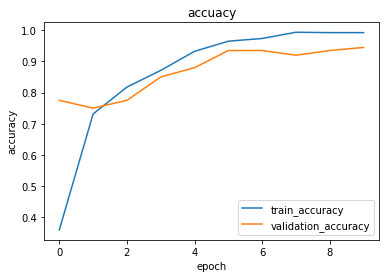

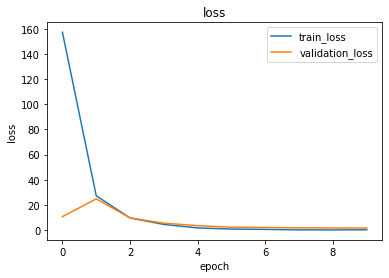

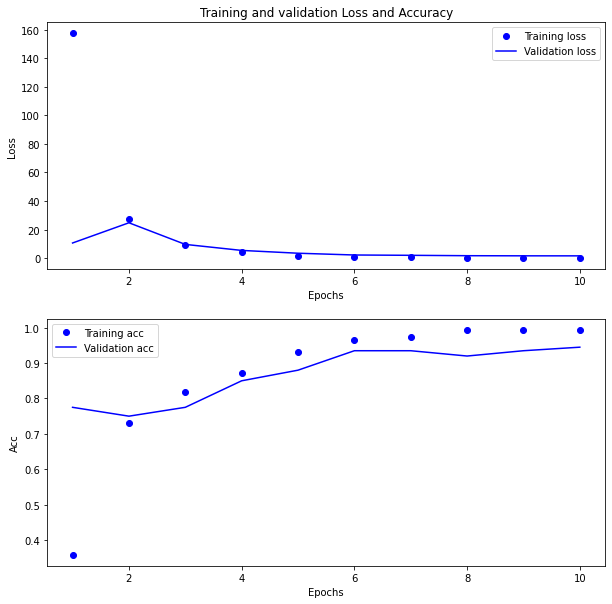

In [18]:
def plot_accuracy(history,title):
    plt.title(title)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
    plt.show()
def plot_loss(history,title):
    plt.title(title)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'validation_loss'], loc='best')
    plt.show()
plot_accuracy(history,'accuacy')
plot_loss(history, 'loss')

# Training curves
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs_x = range(1, len(loss_values) + 1)
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(epochs_x, loss_values, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(2,1,2)
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
plt.plot(epochs_x, acc_values, 'bo', label='Training acc')
plt.plot(epochs_x, val_acc_values, 'b', label='Validation acc')
#plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [19]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import confusion_matrix
y_prediction = model_rn.predict(val_ds)
y_prediction = np.argmax (y_prediction, axis = 1)
labels =  []
for x, y in val_ds:
  for i in y.numpy():
   labels.append(i)
from sklearn.metrics import classification_report
y_test = np.array(labels)
print(confusion_matrix(y_test, y_prediction ))
print(classification_report(y_test, y_prediction))

2/2 [==============================] - 1s 485ms/step
[[42  0  0  0  1]
 [ 0 38  0  0  3]
 [ 1  1 45  0  0]
 [ 1  0  0 29  0]
 [ 3  1  0  0 35]]
              precision    recall  f1-score   support

           0       0.89      0.98      0.93        43
           1       0.95      0.93      0.94        41
           2       1.00      0.96      0.98        47
           3       1.00      0.97      0.98        30
           4       0.90      0.90      0.90        39

    accuracy                           0.94       200
   macro avg       0.95      0.95      0.95       200
weighted avg       0.95      0.94      0.95       200



In [20]:
tf.keras.models.save_model(model_rn,'my_model3.hdf5')

# Evaluation

In [21]:
!pip install image-quality

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 146 kB 39.5 MB/s 
     |████████████████████████████████| 170 kB 69.4 MB/s 
  Created wheel for libsvm: filename=libsvm-3.23.0.4-cp38-cp38-linux_x86_64.whl size=233350 sha256=09999f76cbf498a26af9bedde7156e3c649da74101255d7204f6bd5bfaadbdf0
  Stored in directory: /root/.cache/pip/wheels/41/00/e7/b328c0f5e4bbb9ac8ba5a72e56b1749be63dc1ab1c9321fd4e
Successfully built libsvm


### Quality and Categorization

1/1 [==============================] - 1s 1s/step
This image most likely belongs to lulu with a 100.00 percent confidence and have a Image quality score of 31.15.


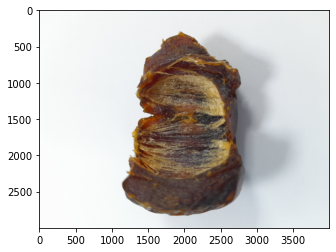

In [22]:
import imquality.brisque as brisque
import PIL.Image
image_path = "/content/open/lulu/10_o.jpg"
img = tf.keras.utils.load_img(
       image_path, target_size=(256, 256, 3)
)
img_array1 = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array1, 0) # Create a batch\n"
predictions = model_rn.predict(img_array)
# score = tf.nn.softmax(predictions[0])
print(
        "This image most likely belongs to {} with a {:.2f} percent confidence and have a Image quality score of {:.2f}."
            .format(class_names[np.argmax(predictions)], 100 * np.max(predictions), brisque.score(PIL.Image.open(image_path)))
        )
# from google.colab.patches import cv2_imshow
# cv2_imshow(img_array1)

import matplotlib.image as mpimg 
from matplotlib.pyplot import imshow
%matplotlib inline
testim = mpimg.imread(image_path)
imshow(testim)

1/1 [==============================] - 0s 23ms/step
This image most likely belongs to fardh with a 100.00 percent confidence and have a Image quality score of 57.04.


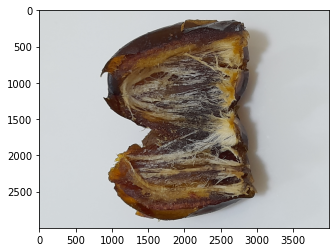

In [24]:
import imquality.brisque as brisque
import PIL.Image
image_path = "/content/open/fardh/101_o.jpg"
img = tf.keras.utils.load_img(
       image_path, target_size=(256, 256, 3)
)
img_array1 = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array1, 0) # Create a batch\n"
predictions = model_rn.predict(img_array)
# score = tf.nn.softmax(predictions[0])
print(
        "This image most likely belongs to {} with a {:.2f} percent confidence and have a Image quality score of {:.2f}."
            .format(class_names[np.argmax(predictions)], 100 * np.max(predictions), brisque.score(PIL.Image.open(image_path)))
        )
# from google.colab.patches import cv2_imshow
# cv2_imshow(img_array1)

import matplotlib.image as mpimg 
from matplotlib.pyplot import imshow
%matplotlib inline
testim = mpimg.imread(image_path)
imshow(testim)

1/1 [==============================] - 0s 27ms/step
This image most likely belongs to shishi with a 100.00 percent confidence and have a Image quality score of 78.48.


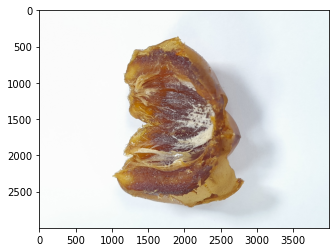

In [27]:
import imquality.brisque as brisque
import PIL.Image
image_path = "/content/open/shishi/172_o.jpg"
img = tf.keras.utils.load_img(
       image_path, target_size=(256, 256, 3)
)
img_array1 = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array1, 0) # Create a batch\n"
predictions = model_rn.predict(img_array)
# score = tf.nn.softmax(predictions[0])
print(
        "This image most likely belongs to {} with a {:.2f} percent confidence and have a Image quality score of {:.2f}."
            .format(class_names[np.argmax(predictions)], 100 * np.max(predictions), brisque.score(PIL.Image.open(image_path)))
        )
# from google.colab.patches import cv2_imshow
# cv2_imshow(img_array1)

import matplotlib.image as mpimg 
from matplotlib.pyplot import imshow
%matplotlib inline
testim = mpimg.imread(image_path)
imshow(testim)

1/1 [==============================] - 0s 24ms/step
This image most likely belongs to bumaan with a 100.00 percent confidence and have a Image quality score of 63.92.


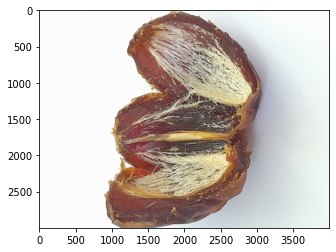

In [28]:
import imquality.brisque as brisque
import PIL.Image
image_path = "/content/open/bumaan/106_o.jpg"
img = tf.keras.utils.load_img(
       image_path, target_size=(256, 256, 3)
)
img_array1 = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array1, 0) # Create a batch\n"
predictions = model_rn.predict(img_array)
# score = tf.nn.softmax(predictions[0])
print(
        "This image most likely belongs to {} with a {:.2f} percent confidence and have a Image quality score of {:.2f}."
            .format(class_names[np.argmax(predictions)], 100 * np.max(predictions), brisque.score(PIL.Image.open(image_path)))
        )
# from google.colab.patches import cv2_imshow
# cv2_imshow(img_array1)

import matplotlib.image as mpimg 
from matplotlib.pyplot import imshow
%matplotlib inline
testim = mpimg.imread(image_path)
imshow(testim)

1/1 [==============================] - 0s 26ms/step
This image most likely belongs to khalas with a 100.00 percent confidence and have a Image quality score of 48.98.


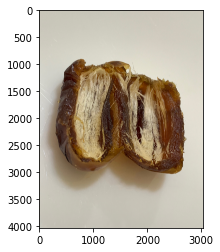

In [29]:
import imquality.brisque as brisque
import PIL.Image
image_path = "/content/open/khalas/104_o.jpg"
img = tf.keras.utils.load_img(
       image_path, target_size=(256, 256, 3)
)
img_array1 = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array1, 0) # Create a batch\n"
predictions = model_rn.predict(img_array)
# score = tf.nn.softmax(predictions[0])
print(
        "This image most likely belongs to {} with a {:.2f} percent confidence and have a Image quality score of {:.2f}."
            .format(class_names[np.argmax(predictions)], 100 * np.max(predictions), brisque.score(PIL.Image.open(image_path)))
        )
# from google.colab.patches import cv2_imshow
# cv2_imshow(img_array1)

import matplotlib.image as mpimg 
from matplotlib.pyplot import imshow
%matplotlib inline
testim = mpimg.imread(image_path)
imshow(testim)